In [45]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

print('Version', torch.__version__) 
print('CUDA enabled:', torch.cuda.is_available())

import os
import pickle
import time
# Running this should then print out:
# Version 1.7.0+cu101 (or something like this)
# CUDA enabled: True

Version 1.7.1
CUDA enabled: True


## Access the dataset 

In [46]:
#For colab version
'''
from google.colab import drive
drive.mount('/content/drive/')
root = "/content/drive/MyDrive/AskaData/AskaData1/aska3bN/cell_small/"
'''

#For desktop version 
root = os.getcwd()

In [47]:
print(root)

/home/olivia/Desktop/final/CSE599FinalProject


## Prepare the data

Example of cell image

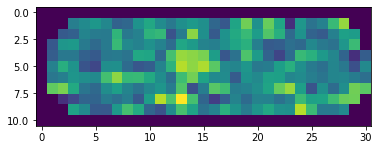

In [48]:
im = plt.imread(root + '/aska1aN/xy16Cell0000359/Cell0000359_frame_2.png')
plt.imshow(im)

In [65]:
tow = data[0,:,:,:].reshape(88,54)

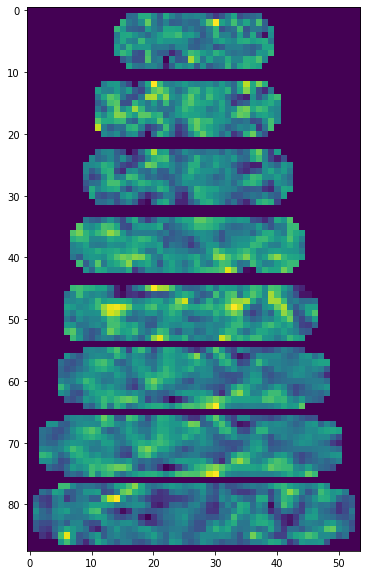

In [66]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(tow)

**Inputs into convolutional LSTM are shaped:**

**tensor of size B, T, C, H, W or T, B, C, H, W**

B = batch

T = timestep

C = channels

H = heights

W = width 

We are currently thinking we do not have to pad the images. 

In [50]:
transform_horizontal = transforms.Compose([
    transforms.RandomHorizontalFlip(1),
])

transform_vertical = transforms.Compose([
    transforms.RandomVerticalFlip(1),
])

transform_both = transforms.Compose([
    transforms.RandomVerticalFlip(1),
    transforms.RandomHorizontalFlip(1),
])

In [51]:
import imageio

In [ ]:
start_time = time.time()

dataDir = root + '/aska1aN'

tower1 = torch.zeros(1,8,11,54)
data = []

for subdir, dirs, files in os.walk(dataDir):
    try:
        tower = [None] * 8
        tower_vert = [None] * 8
        tower_horz = [None] * 8
        tower_both = [None] *8
        for file in files:
            #print(os.path.join(subdir, file))
            im = torch.LongTensor(imageio.imread(os.path.join(subdir, file)))/255

            #Padding
            p = (54 - im.shape[1])//2
            r = (54 - im.shape[1])%2
            m = nn.ConstantPad1d(padding=(p + r, p), value=0)
            im = m(im)
            im = torch.reshape(im, (1,11,54))
            
            im_vert = transform_vertical(im)
            im_horz = transform_horizontal(im)
            im_both = transform_both(im)
    
            try:
                i = int(os.path.join(subdir, file)[-5])
                tower[i - 1] = im
                tower_vert[i - 1] = im_vert
                tower_horz[i - 1] = im_horz
                tower_both[i - 1] = im_both
            except:
                pass
    
        if tower[0] != None:
            #Convert list (tower) of cells into tensor
            tower = torch.stack(tower, dim=0)
            tower_vert = torch.stack(tower_vert, dim=0)
            tower_horz = torch.stack(tower_horz, dim=0)
            tower_both = torch.stack(tower_both, dim=0)
            data.extend([tower, tower_vert, tower_horz, tower_both])
            
    except:
        pass
    
print("--- %s seconds ---" % (time.time() - start_time))

#### Defining the dataloaders 

In [ ]:
n = len(data)
trainLength = (n//5)*4
testLength = n - trainLength

trainset, testset = torch.utils.data.random_split(data, [trainLength, testLength], 
                                                  generator=torch.Generator().manual_seed(42))

d = trainLength
trainLength = (d//5)*4
valLength = d - trainLength


trainset, valset = torch.utils.data.random_split(trainset, [trainLength, valLength], 
                                                  generator=torch.Generator().manual_seed(42))


In [ ]:
testset[0].shape

## Defining the network

### Convolutional LSTM 
Adapted from [ndrplz](https://raw.githubusercontent.com/ndrplz/ConvLSTM_pytorch/master/convlstm.py).

In [ ]:
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

### ConvLSTMNet
Simple model with single convolution LSTM layer. Using this model as a baseline before we add in more convolutional layers and residual connections. 

In [ ]:
class ConvLSTMNet(nn.Module):
    
  def __init__(self, inputChannels, featureSize):
    super(ConvLSTMNet, self).__init__()

    self.c = inputChannels
    self.featureSize = featureSize

    #ConvLSTM uses convolutional operations rather than regular matrix operations
    self.convLSTM = ConvLSTM(input_dim=self.c, hidden_dim=self.featureSize, kernel_size=[(3,3)], num_layers=1,
                            batch_first=True)
    self.conv1 = nn.Conv2d(in_channels=self.featureSize, out_channels=self.c, kernel_size=3, stride=1,
                           padding=1)
    self.bn1 = nn.BatchNorm3d(num_features=7)



  def forward(self, x, hidden = None):
    """
    , hidden=None
    Takes in a batch of data (N, T, 11, 54). Data are sequences of images. The batch is a tensor
    with dimensions N: batch size, 56: width of image, 12: height of image, T: number of timesteps.
    Returns a tensor of shape (N, 1, 11, 56) which is the predicted next frame in the sequence.
    Also returns an encoded label indicating which protein type the sequence contains. 
        
    :param batch: Tensor of shape (N, T, 11, 54) Batch of time series frames. Dimensions: N 
    (number of samples) by 56 (width of image) by 12 (height of image) by T (number of timesteps). 

    :return prediction: Tensor of shape (N, 1, 11, 54). Dimensions: N (number of samples) by 
    54 (width of image) by 11 (height of image) by 1 (number of timesteps in the future). 

    """
    x = x.float() 
     
    x = F.relu(x)
    x = self.bn1(x)
    
    x, hidden = self.convLSTM(x, hidden)
    hidden = self.conv1(hidden[0][0])
    
    return x, hidden
  

## Training

In [ ]:
import tqdm
def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)


def train(model, device, optimizer, trainloader, valloader, lr, epoch, log_interval):
    model.train()
    losses = []
    valLosses = []
    hidden = None
    


    for i, data in enumerate(trainloader, 0):
        #Inputs are first 7 cells in a tower, outputs are cell in a tower 
        inputs = torch.stack([x[0:7,:,:,:].reshape(7,1,11,54) for x in data])
        outputs = torch.stack([x[7,:,:,:].reshape(1,11,54) for x in data])
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        # Separates the hidden state across batches. 
        # Otherwise the backward would try to go all the way to the beginning every time.
        if hidden is not None:
            hidden = repackage_hidden(hidden)
            
        optimizer.zero_grad()
        preds_train, hidden = model(inputs)
        
        #print('inputs ',inputs.shape)
        #print('outputs ',outputs.shape)
        #print('preds_train ',preds_train.shape)

        loss = torch.sqrt(F.mse_loss(hidden[0][0],outputs.float()))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        if i % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(trainloader.dataset),
                100. * i / len(trainloader), loss.item()))   
            
    train = [[data], [hidden]]

    #Validation       
    for i, data in enumerate(valloader, 0):
        inputs = torch.stack([x[0:7,:,:,:].reshape(7,1,11,54) for x in data])
        outputs = torch.stack([x[7,:,:,:].reshape(1,11,54) for x in data])
        inputs = inputs.to(device)
        outputs = outputs.to(device)

        if hidden is not None:
          hidden = repackage_hidden(hidden)

        preds_val, hidden = model(inputs)
        loss = torch.sqrt(F.mse_loss(hidden[0][0],outputs))
        valLosses.append(loss.item())
        if i % log_interval == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tVal Loss: {:.6f}'.format(
                  epoch, i * len(data), len(valloader.dataset),
                  100. * i / len(valloader), loss.item()))
                
    val = [[data], [hidden]]
                
    return np.mean(losses), np.mean(valLosses), train, val


def test(model, device, test_loader):
    model.eval()
    testLosses = []
    
    with torch.no_grad():
        hidden = None
        for i, data in enumerate(testloader, 0):
            inputs = torch.stack([x[0:7,:,:,:].reshape(7,1,11,54) for x in data])
            outputs = torch.stack([x[7,:,:,:].reshape(1,11,54) for x in data])
            inputs = inputs.to(device)
            outputs = outputs.to(device)


            preds_test, hidden = model(inputs)
            loss = torch.sqrt(F.mse_loss(hidden[0][0],outputs))
            testLosses.append(loss.item())
            
        test = [[data], [hidden]]

    return np.mean(testLosses), test

In [ ]:
def main(trainloader, valloader, testloader, BATCH_SIZE = 256, 
         FEATURE_SIZE = 64, TEST_BATCH_SIZE = 256, EPOCHS = 2, 
         LEARNING_RATE = 0.002, WEIGHT_DECAY = 0.0005, EXP_VER = '00001',
         data_train = trainset, data_val = valset, data_test = testset):
  
    PRINT_INTERVAL = 1
    USE_CUDA = True
    LOG_PATH = root + EXP_VER + 'logs/log.pkl'
    
    test_losses = []
    train_losses = []
    val_losses = []
    trainPredictions = []
    valPredictions = []
    testPredictions = []

    use_cuda = USE_CUDA and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")
    print('Using device', device)
    import multiprocessing
    num_workers = multiprocessing.cpu_count()
    print('num workers:', num_workers)

    kwargs = {'num_workers': num_workers,
              'pin_memory': True} if use_cuda else {}

    model = ConvLSTMNet(inputChannels=1, featureSize=FEATURE_SIZE).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    start_epoch = 0

    test_loss, testPredicts = test(model, device, testloader)
    test_losses.append((start_epoch, test_loss/len(testset)))

    try:
      for epoch in range(start_epoch, EPOCHS + 1):
        lr = LEARNING_RATE
        train_loss, val_loss, trainPredicts, valPredicts = train(model, device, optimizer,
                                                                 trainloader, valloader,
                                                                 lr, epoch, PRINT_INTERVAL)
        test_loss, testPredicts = test(model, device, testloader)

        train_losses.append((epoch, train_loss))
        val_losses.append((epoch, val_loss))
        test_losses.append((epoch, test_loss))
        
        trainPredictions.append((epoch, trainPredicts))
        valPredictions.append((epoch, valPredicts))
        testPredictions.append((epoch, testPredicts))


    except KeyboardInterrupt as ke:
        print('Interrupted')
    except:
        import traceback
        traceback.print_exc()
    finally:
        print('Saving final model')
        # Specify a path
        modelName = EXP_VER + "_state_dict_model.pt"
        PATH = os.path.join(root, modelName)
        torch.save(model.state_dict(), PATH)
        histories = zip(train_losses, val_losses, test_losses) 
        predictions = zip(trainPredictions[-1], valPredictions[-1], testPredictions[-1])
        historyFile = EXP_VER + '_history.pkl'
        predictionsFile = EXP_VER + '_predictions.pkl'
        pickle.dump(histories, open(os.path.join(root, historyFile), 'wb'))
        pickle.dump(predictions, open(os.path.join(root, predictionsFile), 'wb'))
        
    return model, device, histories, predictions

In [ ]:
start_time = time.time()

batchSize = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize,
                                              shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchSize, 
                                            shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize,
                                             shuffle=False)
    

model, device, histories, predictions = main(trainloader, valloader, testloader,
                     BATCH_SIZE = batchSize, FEATURE_SIZE = 4, TEST_BATCH_SIZE = 128, 
                     EPOCHS = 120, LEARNING_RATE = 0.002, WEIGHT_DECAY = 0.0005, EXP_VER = '23')

print("--- %s seconds ---" % (time.time() - start_time))

In [52]:
historyFile = '22' + '_history.pkl'
losses = pickle.load(open(os.path.join(root, historyFile), 'rb'))

In [53]:
trainLoss, valLoss, testLoss = zip(*losses)

Text(0, 0.5, 'Mean-squared Error')

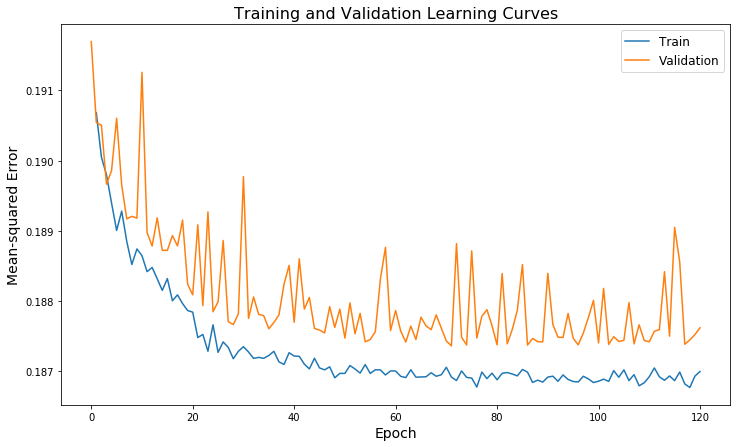

In [54]:
fig, ax = plt.subplots(1,1, figsize=(12,7))

epoch, loss = zip(*trainLoss)
ax.plot(epoch[1:], loss[1:], label="Train")
epoch, loss = zip(*valLoss)
ax.plot(epoch[0:], loss[0:], label="Validation")

ax.legend(fontsize=12)
ax.set_title('Training and Validation Learning Curves', fontsize=16)
ax.set_xlabel('Epoch', fontsize = 14)
ax.set_ylabel('Mean-squared Error', fontsize=14)

In [56]:
predictFile = '22' + '_predictions.pkl'
predictions = pickle.load(open(os.path.join(root, predictFile), 'rb'))

In [57]:
train, val, test = zip(*predictions)

In [58]:
data = train[1][0][0]
preds = train[1][1][0]

In [59]:
data.shape

torch.Size([76, 8, 1, 11, 54])

In [60]:
preds.shape

torch.Size([76, 1, 11, 54])

In [61]:
tow = data[0,:,:,:].reshape(88,54)

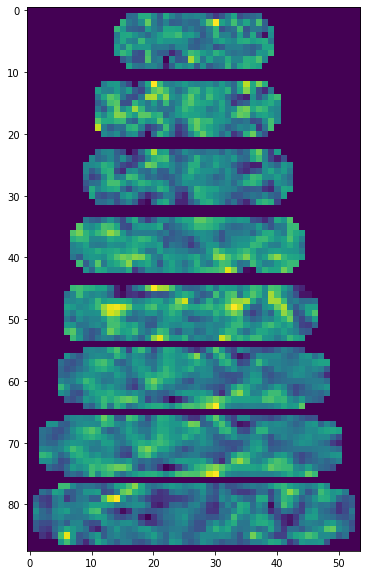

In [63]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(tow)

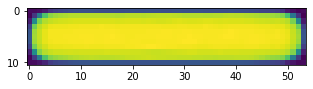

In [64]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(preds[0,:,:,:].cpu().detach().reshape(11,54))

In [ ]:
preds.shape

In [ ]:
use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
PATH = root + '/22_state_dict_model.pt'
model = ConvLSTMNet(inputChannels=1, featureSize=4).to(device)

model.load_state_dict(torch.load(PATH))

In [ ]:
testloader = torch.utils.data.DataLoader(data, batch_size=1,
                                             shuffle=False)

In [ ]:
test_loss, testPredicts = test(model, device, testloader)

In [ ]:
data = testPredicts[1][0]
preds = testPredicts[1][0]

In [ ]:
data.shape

In [ ]:
preds.shape

In [ ]:
plt.imshow(preds.cpu().detach().reshape(11,54))